[Understanding KL Divergence](https://sidml.github.io/Understanding-KL-Divergence/)

In [2]:
import pdb
import numpy as np
import torch
from torch.autograd import grad
import torch.nn.functional as F
import matplotlib.pyplot as plt


import matplotlib.animation
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

from typing import Dict, List, Tuple

In [5]:
plt.rcParams.update({'font.size': 18})

In [3]:
mu1, sigma1 = -5, 1
mu2, sigma2 = 10, 1
gaussian1 = torch.distributions.Normal(mu1, sigma1)
gaussian2 = torch.distributions.Normal(mu2, sigma2)

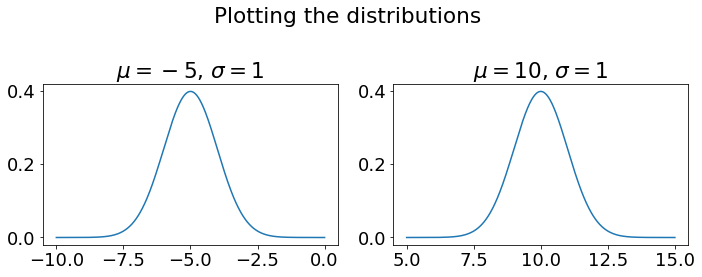

In [9]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))
x = torch.linspace(mu1 - 5*sigma1, mu1 + 5*sigma1, 1000)
ax[0].plot(x.numpy(), gaussian1.log_prob(x).exp().numpy(), label='p(x)')
ax[0].set_title(f"$\mu ={mu1}$, $\sigma={sigma1}$")

x = torch.linspace(mu2 - 5*sigma2, mu2 + 5*sigma2, 1000)
ax[1].plot(x.numpy(), gaussian2.log_prob(x).exp().numpy(), label='p(x)')
ax[1].set_title(f"$\mu ={mu2}$, $\sigma={sigma2}$")
fig.suptitle("Plotting the distributions");
plt.tight_layout()

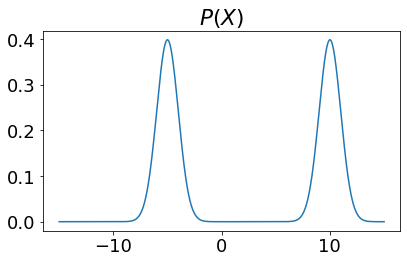

In [12]:
# Constructing P(X)
fig, ax = plt.subplots(1, figsize=(6, 4))

x = torch.linspace(-mu1-mu2-5*sigma1-5*sigma2, mu1+mu2+5*sigma1+5*sigma2, 1000)
px = gaussian1.log_prob(x).exp() + gaussian2.log_prob(x).exp()
ax.plot(x.numpy(), px.numpy(), label='p(x)')
ax.set_title("$P(X)$");
plt.tight_layout()

We will be using a gaussian distribution to approximate $P(X)$. We don’t know the optimal paramters that will best approximate the distribution $P(X)$. So, let us simply take $\mu=0,\sigma=1$ as our starting point.

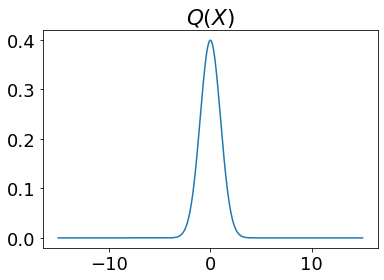

In [16]:
# Constructiong Q(X)
mu = torch.tensor([0.0])
sigma = torch.tensor([1.0])

x = torch.linspace(-mu1-mu2-5*sigma1-5*sigma2, mu1+mu2+5*sigma1+5*sigma2, 1000)
Q = torch.distributions.Normal(mu, sigma) # this should approximate P, eventually :-)
qx = Q.log_prob(x).exp()
plt.plot(x.numpy(), qx.numpy())
plt.title("$Q(X)$");


### KL-Divergence

The thing to note is that the input given is expected to contain log-probabilities. The targets are given as probabilities (i.e. without taking the logarithm).

In [17]:
px = gaussian1.log_prob(x).exp() + gaussian2.log_prob(x).exp()
qx = Q.log_prob(x).exp()
F.kl_div(qx.log(), px, reduction='sum')

tensor(inf)

In [18]:
px = gaussian1.log_prob(x).exp() + gaussian2.log_prob(x).exp()
qx = Q.log_prob(x)
F.kl_div(qx,px)

tensor(2.0812)

In [20]:
def optimize_loss(x: torch.tensor,
                  px: torch.tensor,
                  loss_fn: str = "kl_div",
                  muq: float = 0.0,
                  sigmaq: float = 1.0,
                  subsample_factor: int = 3,
                  mode: str = 'min') -> Tuple[float, float, List[int]]:

    mu = torch.tensor([muq], requires_grad=True)
    sigma = torch.tensor([sigmaq], requires_grad=True)

    opt = torch.optim.Adam([mu, sigma])

    loss_val = []
    epochs = 10000

    # required for animation
    all_qx, all_mu = [], []

    torch_loss_fn = getattr(F, loss_fn)
    for i in range(epochs):
        Q = torch.distributions.Normal(mu, sigma)  # this should approximate P
        # we need to exponentiate q(x) for these and few other cases
        if loss_fn != 'kl_div':
            qx = Q.log_prob(x).exp()
            all_qx.append(qx.detach().numpy()[::subsample_factor])
        else:
            qx = Q.log_prob(x)
            all_qx.append(qx.exp().detach().numpy()[::subsample_factor])

        if mode == 'min':
            loss = torch_loss_fn(qx, px)
        else:
            loss = -torch_loss_fn(qx, px, dim=0)
    #   backward pass
        opt.zero_grad()
        loss.backward()
        opt.step()
        loss_val.append(loss.detach().numpy())
        all_mu.append(mu.data.numpy()[0])

        if i % (epochs//10) == 0:
            print('Epoch:', i, 'Loss:', loss.data.numpy(), 'mu',
                  mu.data.numpy()[0], 'sigma', sigma.data.numpy()[0])

    print('Epoch:', i, 'Loss:', loss.data.numpy(), 'mu',
          mu.data.numpy()[0], 'sigma', sigma.data.numpy()[0])

    plt.figure(figsize=(14, 6))
    plt.subplot(2, 2, 1)
    plt.plot(loss_val)
    plt.xlabel('epoch')
    plt.ylabel(f'{loss_fn} (Loss)')
    plt.title(f'{loss_fn} vs epoch')

    plt.subplot(2, 2, 2)
    plt.plot(all_mu)
    plt.xlabel('epoch')
    plt.ylabel('$\mu$')
    plt.title('$\mu$ vs epoch')

    return mu.data.numpy()[0], sigma.data.numpy()[0], all_qx

Epoch: 0 Loss: 2.081249 mu 0.0009999998 sigma 1.001
Epoch: 1000 Loss: 0.7304137 mu 0.7143856 sigma 1.6610031
Epoch: 2000 Loss: 0.4642204 mu 1.1925318 sigma 2.093055
Epoch: 3000 Loss: 0.34432057 mu 1.5722022 sigma 2.4694302
Epoch: 4000 Loss: 0.27543005 mu 1.8818175 sigma 2.8316045
Epoch: 5000 Loss: 0.23109898 mu 2.126466 sigma 3.1971986
Epoch: 6000 Loss: 0.20085065 mu 2.3044739 sigma 3.5747757
Epoch: 7000 Loss: 0.1796072 mu 2.4167945 sigma 3.96797
Epoch: 8000 Loss: 0.16454785 mu 2.4736755 sigma 4.37706
Epoch: 9000 Loss: 0.15392812 mu 2.494548 sigma 4.799748
Epoch: 9999 Loss: 0.14657247 mu 2.4993846 sigma 5.231065


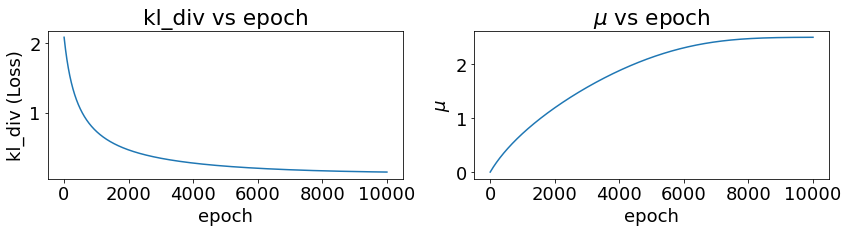

In [21]:
x = torch.linspace(-mu1-mu2-5*sigma1-5*sigma2, mu1+mu2+5*sigma1+5*sigma2, 1000)
px = gaussian1.log_prob(x).exp() + gaussian2.log_prob(x).exp()
mu, sigma, all_qx = optimize_loss(x, px, loss_fn='kl_div', muq=0.0, sigmaq=1.0)

In [22]:
def create_animation(x: torch.tensor, px: torch.tensor, all_qx: List, subsample_factor: int = 3,
                     fn: str = 'anim_distr.gif') -> None:

    # create a figure, axis and plot element
    fig = plt.figure()
    ax = plt.axes(xlim=(x.min(), x.max()), ylim=(0, 0.5))
    text = ax.text(3, 0.3, 0)
    line1, = ax.plot([], [], color="r")
    line2, = ax.plot([], [], color="g", alpha=0.7)

    def animate(i):
        #     non uniform sampling, interesting stuff happens fast initially
        if i < 75:
            line1.set_data(x[::subsample_factor].numpy(), all_qx[i*50])
            text.set_text(f'epoch={i*50}')
            line2.set_data(x[::subsample_factor].numpy(),
                           px.numpy()[::subsample_factor])
        else:
            line1.set_data(x[::subsample_factor].numpy(), all_qx[i*100])
            text.set_text(f'epoch={i*100}')
            line2.set_data(x[::subsample_factor].numpy(),
                           px.numpy()[::subsample_factor])

        return [line1, line2]

    ani = matplotlib.animation.FuncAnimation(
        fig, animate, frames=100, interval=200, blit=True)

    fig.suptitle(f'Minimizing the {fn[:-3]}')
    ax.legend(['Approximation', 'Actual Distribution'])
    # save the animation as gif
    ani.save(fn, writer='imagemagick', fps=10)

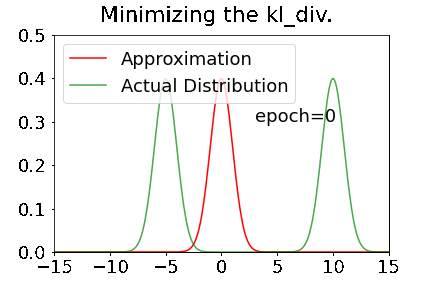

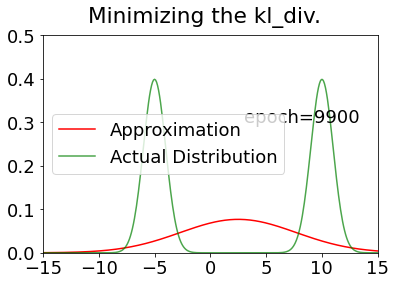

In [23]:
ani = create_animation(x, px, all_qx, fn='kl_div.gif')
Image("kl_div.gif")

Epoch: 0 Loss: 0.028145004 mu -0.0009998897 sigma 1.001
Epoch: 1000 Loss: 0.020257153 mu -1.6214695 sigma 1.8781366
Epoch: 2000 Loss: 0.015502929 mu -2.8332014 sigma 2.3772995
Epoch: 3000 Loss: 0.0136076175 mu -3.720928 sigma 2.347684
Epoch: 4000 Loss: 0.010931816 mu -4.580787 sigma 1.6035494
Epoch: 5000 Loss: 0.009393813 mu -4.997198 sigma 1.0015947
Epoch: 6000 Loss: 0.009393757 mu -4.9999804 sigma 1.0000038
Epoch: 7000 Loss: 0.009393757 mu -4.999988 sigma 1.0000023
Epoch: 8000 Loss: 0.009393757 mu -4.999993 sigma 1.0000013
Epoch: 9000 Loss: 0.009393757 mu -4.9999957 sigma 1.0000008
Epoch: 9999 Loss: 0.009393757 mu -4.9999976 sigma 1.0000005


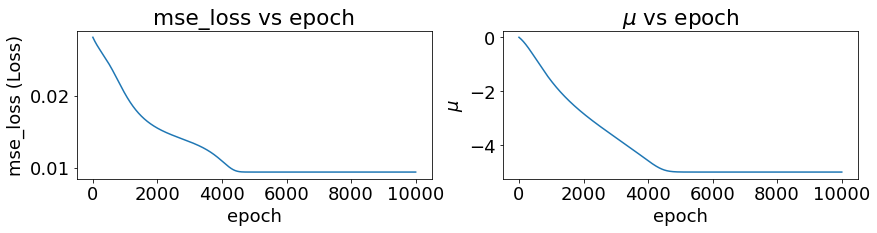

In [24]:
x = torch.linspace(-mu1-mu2-5*sigma1-5*sigma2, mu1+mu2+5*sigma1+5*sigma2, 1000)
px = gaussian1.log_prob(x).exp() + gaussian2.log_prob(x).exp()
mu, sigma, all_qx = optimize_loss(x, px, loss_fn='mse_loss', muq=0.0, sigmaq=1.0)

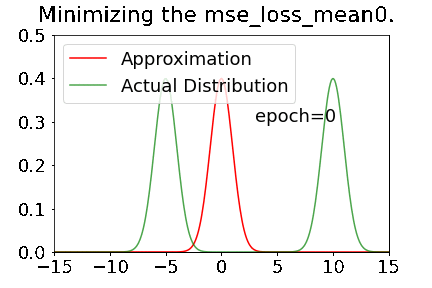

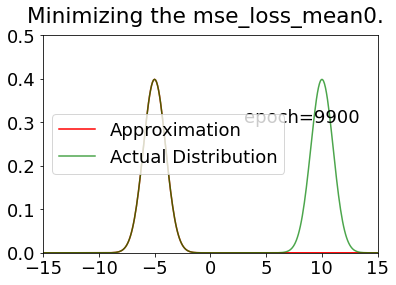

In [25]:
fn = 'mse_loss_mean0.gif'
ani = create_animation(x,px,all_qx,fn=fn)
Image(f"{fn}")

Epoch: 0 Loss: -0.0013650373 mu 5.001 sigma 1.001
Epoch: 1000 Loss: -0.25994548 mu 6.614415 sigma 2.443387
Epoch: 2000 Loss: -0.4190549 mu 7.6862507 sigma 2.9858634
Epoch: 3000 Loss: -0.5015171 mu 8.5627165 sigma 2.7770283
Epoch: 4000 Loss: -0.64180714 mu 9.502896 sigma 1.6784608
Epoch: 5000 Loss: -0.70708656 mu 9.990341 sigma 1.0044081
Epoch: 6000 Loss: -0.7071069 mu 9.999949 sigma 1.0000044
Epoch: 7000 Loss: -0.7071068 mu 9.9999695 sigma 1.0000026
Epoch: 8000 Loss: -0.7071067 mu 9.999982 sigma 1.0000015
Epoch: 9000 Loss: -0.7071069 mu 9.9999895 sigma 1.0000011
Epoch: 9999 Loss: -0.70710677 mu 9.999993 sigma 1.0000004


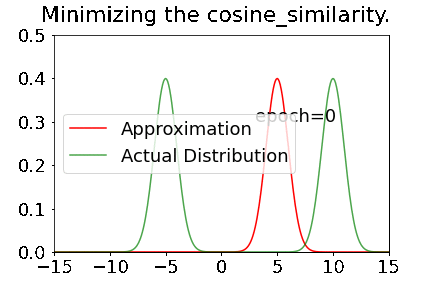

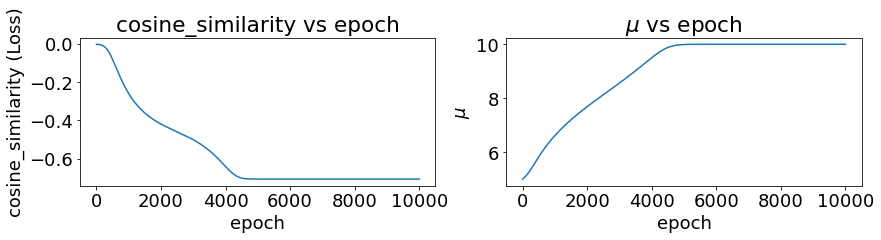

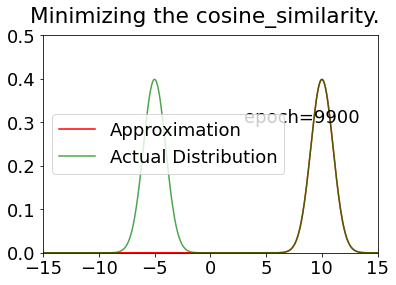

In [26]:
x = torch.linspace(-mu1-mu2-5*sigma1-5*sigma2, mu1+mu2+5*sigma1+5*sigma2, 1000)
px = gaussian1.log_prob(x).exp() + gaussian2.log_prob(x).exp()
mu, sigma, all_qx = optimize_loss(
    x, px, loss_fn='cosine_similarity', muq=5.0, sigmaq=1.0, mode='max')

fn = 'cosine_similarity.gif'
ani = create_animation(x, px, all_qx, fn=fn)
Image(f"{fn}")